## Final Analysis
This Notebook creates a simple averaging ensemble model for the various models investigated. This also visualizes the emissions results for each model.

In [ ]:
# neccessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from keras.models import load_model
from datetime import datetime
from google.colab import drive
from google.colab import files
import sys
import joblib
import gc
import zipfile
import warnings
warnings.filterwarnings('ignore')
#seed for reproducibility
np.random.seed(42)



drive.mount('/content/drive', force_remount = True)
file_path = '/content/drive/My Drive/FILE_PATH' #Replace FILE_PATH with the actual file destination or upload directly to notebook
#reading
df_1 = pd.read_csv(file_path + 'feature_engineered_data_1.csv', infer_datetime_format=True)
df_2 = pd.read_csv(file_path + 'feature_engineered_data_2.csv',infer_datetime_format=True)

#copy this file to the Colab Directory - alternatively: just download and upload directly
!cp '/content/drive/MyDrive/Semester 2/FILE_PATH/eval_metrics_cv.py' . #replace FILE_PATH with actual file path.
# Add the directory containing eval_metrics.py to the system path
sys.path.append('.')

from eval_metrics_cv import mae_calc, rmse_calc, smape_calc, rolling_cv

Mounted at /content/drive


In [ ]:
#splitting the data, 90% training model and tuning, 5% test and refit, 5% for later final meta evaluation

#df_1
total_df_1_len = len(df_1)
train_df_1_len = int(0.9 * total_df_1_len)
refit_df_1_len = int(0.05 * total_df_1_len)
meta_df_1_len = int(0.05 * total_df_1_len)

#creating splits
train_df_1 = df_1.iloc[:train_df_1_len]
refit_df_1 = df_1.iloc[train_df_1_len:train_df_1_len + refit_df_1_len]
meta_df_1 = df_1.iloc[train_df_1_len + refit_df_1_len:]

#df_2
total_df_2_len = len(df_2)
train_df_2_len = int(0.9 * total_df_2_len)
refit_df_2_len = int(0.05 * total_df_2_len)
meta_df_2_len = int(0.05 * total_df_2_len)

#creating splits
train_df_2 = df_2.iloc[:train_df_2_len]
refit_df_2 = df_2.iloc[train_df_2_len:train_df_2_len + refit_df_2_len]
meta_df_2 = df_2.iloc[train_df_2_len + refit_df_2_len:]

In [ ]:
file_path_models = '/content/drive/My Drive/FILE_PATH' #replace FILE_PATH with relevant location
lin_reg_df_1 = joblib.load(file_path_models + 'best_model_df_1.pkl')
lin_reg_df_2 = joblib.load(file_path_models + 'best_model_df_2.pkl')
arima_df_1 = joblib.load(file_path_models + 'final_model_arima_1.pkl')
arima_df_2 = joblib.load(file_path_models + 'final_model_arima_2.pkl')
arimax_df_1 = joblib.load(file_path_models + 'final_model_arimax_1.pkl')
arimax_df_2 = joblib.load(file_path_models + 'final_model_arimax_2.pkl')
lstm_uni_df_1 = joblib.load(file_path_models + 'model_best_lstm_df_1.pkl')
lstm_uni_df_2 = joblib.load(file_path_models + 'model_best_lstm_df_2.pkl')
lstm_multi_df_1 = joblib.load(file_path_models + 'model_best_lstm_multi_df_1.pkl')
lstm_multi_df_2 = joblib.load(file_path_models + 'model_best_lstm_multi_df_2.pkl')


# Data Preparation for each model

The neccessary data preparation code has to be extracted from each model notebook to prepare the unseen data here for each model.

In [ ]:
#linreg and arima data prep -calling exog just to make it compatible for both
meta_target_col = 'Close_UTC_00'
exog_cols_1 = ['Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
exog_cols_2 = ['avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']

In [ ]:
#lstm data prep- time splits
n_steps = 7
# creating the split or history for each point
def hist(sequence, n_steps):
  """
  Creates Input/Target Sequenecs for the Univariate Time Series Approach
  """
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    seq_x = sequence[i:i + n_steps]
    seq_y = sequence[i + n_steps]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y) #np arrays for easier use in model an computation

#multi
def hist_multi(sequence, n_steps):
  """
  Creates Input/Target Sequenecs for the Multivariate Time Series Approach
  """
  X, y = list(), list()
  for i in range(len(sequence) - n_steps):
    seq_x = sequence[i:i + n_steps, :] #seq of features from i to i +n_steps
    seq_y = sequence[i + n_steps, 0] #asserting that the BTC Close Price is the first column
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y) #np arrays for easier use in model an computation

In [ ]:
#defining model functions
def linreg_predict(meta_df, model, exog_cols):
  X = meta_df[exog_cols].copy()
  X = sm.add_constant(X) #, has_constant='add'
  return model.predict(X)

def arima_predict(meta_df, model):
  return model.predict(start=meta_df.index[0], end=meta_df.index[-1])

def arimax_predict(meta_df, model, exog_cols):
  #adjusting indices
  X_exog = meta_df[exog_cols].copy()
  n_steps=len(X_exog)

  #index
  start_index = len(model.data.endog)
  end_index = start_index + n_steps - 1
  return model.predict(start=start_index, end=end_index , exog=X_exog)

def lstm_uni_predict(meta_df, model):
  data = meta_df['Close_UTC_00'].to_numpy()
  X, y = hist(data, n_steps)
  X = X.reshape((X.shape[0], X.shape[1], 1))
  y_pred = model.predict(X, verbose=0)
  return y_pred.flatten(), y

def lstm_multi_predict(meta_df, model, exog_cols):
  data = meta_df[exog_cols].to_numpy()
  X, y = hist_multi(data, n_steps)
  y_pred = model.predict(X, verbose=0)
  return y_pred.flatten(), y

In [ ]:
#linreg and arima data prep -calling exog just to make it compatible for both
#meta_target_col = 'Close_UTC_00'
exog_cols_1_lstm = ['Close_UTC_00', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']
exog_cols_2_lstm = ['Close_UTC_00', 'avg_sentiment_score', 'Close Value Apple', 'Close Value SPDR S&P 500 ETF Trust', 'Close Value Coinbase', 'RSI'	,'Close_UTC_00_lag1'	,'Close_UTC_00_lag3'	,'Close_UTC_00_lag7'	,'RSI_lag1',	'RSI_lag3',	'RSI_lag7',	'MONTH',	'DAY']

In [ ]:
#applying to datasets

#dataset 1 - df_1
preds_linreg_df_1 = linreg_predict(meta_df_1, lin_reg_df_1, exog_cols_1)
preds_arima_df_1 = arima_predict(meta_df_1, arima_df_1)
preds_arimax_df_1 = arimax_predict(meta_df_1, arimax_df_1, exog_cols_1)
preds_lstm_uni_df_1, _ = lstm_uni_predict(meta_df_1, lstm_uni_df_1)
preds_lstm_multi_df_1, _ = lstm_multi_predict(meta_df_1, lstm_multi_df_1, exog_cols_1_lstm)


#df_2
preds_linreg_df_2 = linreg_predict(meta_df_2, lin_reg_df_2, exog_cols_2)
preds_arima_df_2 = arima_predict(meta_df_2, arima_df_2)
preds_arimax_df_2 = arimax_predict(meta_df_2, arimax_df_2, exog_cols_2)
preds_lstm_uni_df_2, _ = lstm_uni_predict(meta_df_2, lstm_uni_df_2)
preds_lstm_multi_df_2, _ = lstm_multi_predict(meta_df_2, lstm_multi_df_2, exog_cols_2_lstm)


#Predicting and creating Ensemble

In [ ]:
#get evaluation metric results for each of these models
#mae rsme smape
y_true_df_1 = meta_df_1['Close_UTC_00'].iloc[n_steps:].reset_index(drop=True)
y_true_df_2 = meta_df_2['Close_UTC_00'].iloc[n_steps:].reset_index(drop=True)

def align(y_true, y_pred):
  min_len = min(len(y_true), len(y_pred))
  return y_true[:min_len], y_pred[:min_len]

#print predictions
def metrics_print(y_true, y_pred, model_name, dataset_name):
  y_true, y_pred = align(y_true, y_pred)
  mae = mae_calc(y_true, y_pred)
  rmse = rmse_calc(y_true, y_pred)
  smape = smape_calc(y_true, y_pred)
  print(f"Model: {model_name} | Dataset: {dataset_name}")
  print(f"MAE: {mae}")
  print(f"RMSE: {rmse}")
  print(f"SMAPE: {smape}")

#df_1
metrics_print(y_true_df_1, preds_linreg_df_1, 'Linear Regression', 'df_1')
metrics_print(y_true_df_1, preds_arima_df_1, 'ARIMA', 'df_1')
metrics_print(y_true_df_1, preds_arimax_df_1, 'ARIMAX', 'df_1')
metrics_print(y_true_df_1, preds_lstm_uni_df_1, 'LSTM Uni', 'df_1')
metrics_print(y_true_df_1, preds_lstm_multi_df_1, 'LSTM Multi', 'df_1')

#df2
metrics_print(y_true=y_true_df_2, y_pred=preds_linreg_df_2, model_name='Linear Regression', dataset_name='df_2')
metrics_print(y_true=y_true_df_2, y_pred=preds_arima_df_2, model_name='ARIMA', dataset_name='df_2')
metrics_print(y_true=y_true_df_2, y_pred=preds_arimax_df_2, model_name='ARIMAX', dataset_name='df_2')
metrics_print(y_true=y_true_df_2, y_pred=preds_lstm_uni_df_2, model_name='LSTM Uni', dataset_name='df_2')
metrics_print(y_true=y_true_df_2, y_pred=preds_lstm_multi_df_2, model_name='LSTM Multi', dataset_name='df_2')

Model: Linear Regression | Dataset: df_1
MAE: 0.06515082334133608
RMSE: 0.07971431426348045
SMAPE: 8.668657082893038
Model: ARIMA | Dataset: df_1
MAE: 0.33267192623158653
RMSE: 0.33709685726736766
SMAPE: 36.43443224200398
Model: ARIMAX | Dataset: df_1
MAE: 0.3742340125601076
RMSE: 0.38581378669261057
SMAPE: 39.804324548537444
Model: LSTM Uni | Dataset: df_1
MAE: 0.04334043543295023
RMSE: 0.054469937983407025
SMAPE: 5.752316025415326
Model: LSTM Multi | Dataset: df_1
MAE: 0.05486597445759009
RMSE: 0.06650179395472475
SMAPE: 7.138668210579609
Model: Linear Regression | Dataset: df_2
MAE: 0.09612030056788139
RMSE: 0.09706677151718963
SMAPE: 200.0
Model: ARIMA | Dataset: df_2
MAE: 0.1392339714002055
RMSE: 0.1393325492863681
SMAPE: 93.11034255679631
Model: ARIMAX | Dataset: df_2
MAE: 0.04808489290722848
RMSE: 0.04923879273920298
SMAPE: 46.182542658022705
Model: LSTM Uni | Dataset: df_2
MAE: 0.011519937318909018
RMSE: 0.012675886531978865
SMAPE: 15.27377791948842
Model: LSTM Multi | Dataset:

In [ ]:
##ensemble
y_true_df_1 = meta_df_1['Close_UTC_00'].iloc[n_steps:].reset_index(drop=True)
y_true_df_2 = meta_df_2['Close_UTC_00'].iloc[n_steps:].reset_index(drop=True)


#collect preds for df_1
all_preds_df_1 = np.vstack([
    preds_linreg_df_1[n_steps:],
    preds_arima_df_1[n_steps:],
    preds_arimax_df_1[n_steps:],
    preds_lstm_uni_df_1,
    preds_lstm_multi_df_1
])

#collect preds for df_2
all_preds_df_2 = np.vstack([
    preds_linreg_df_2[n_steps:],
    preds_arima_df_2[n_steps:],
    preds_arimax_df_2[n_steps:],
    preds_lstm_uni_df_2,
    preds_lstm_multi_df_2
])


#create ensembles for each
ensemble_df_1 = np.mean(all_preds_df_1, axis=0)
ensemble_df_2 = np.mean(all_preds_df_2, axis=0)

#evaluated each
for i, (y_true,ensemble_preds) in enumerate([(y_true_df_1, ensemble_df_1), (y_true_df_2, ensemble_df_2)]):
  print(f"\n Dataset df_{i} Evaluation")
  print(f"MAE: {mae_calc(y_true, ensemble_preds)}")
  print(f"RMSE: {rmse_calc(y_true, ensemble_preds)}")
  print(f"SMAPE: {smape_calc(y_true, ensemble_preds) }")


 Dataset df_0 Evaluation
MAE: 0.1597349743287517
RMSE: 0.16516336632821038
SMAPE: 19.37312254948616

 Dataset df_1 Evaluation
MAE: 0.028177837967056286
RMSE: 0.02890286182249303
SMAPE: 30.08852270998274


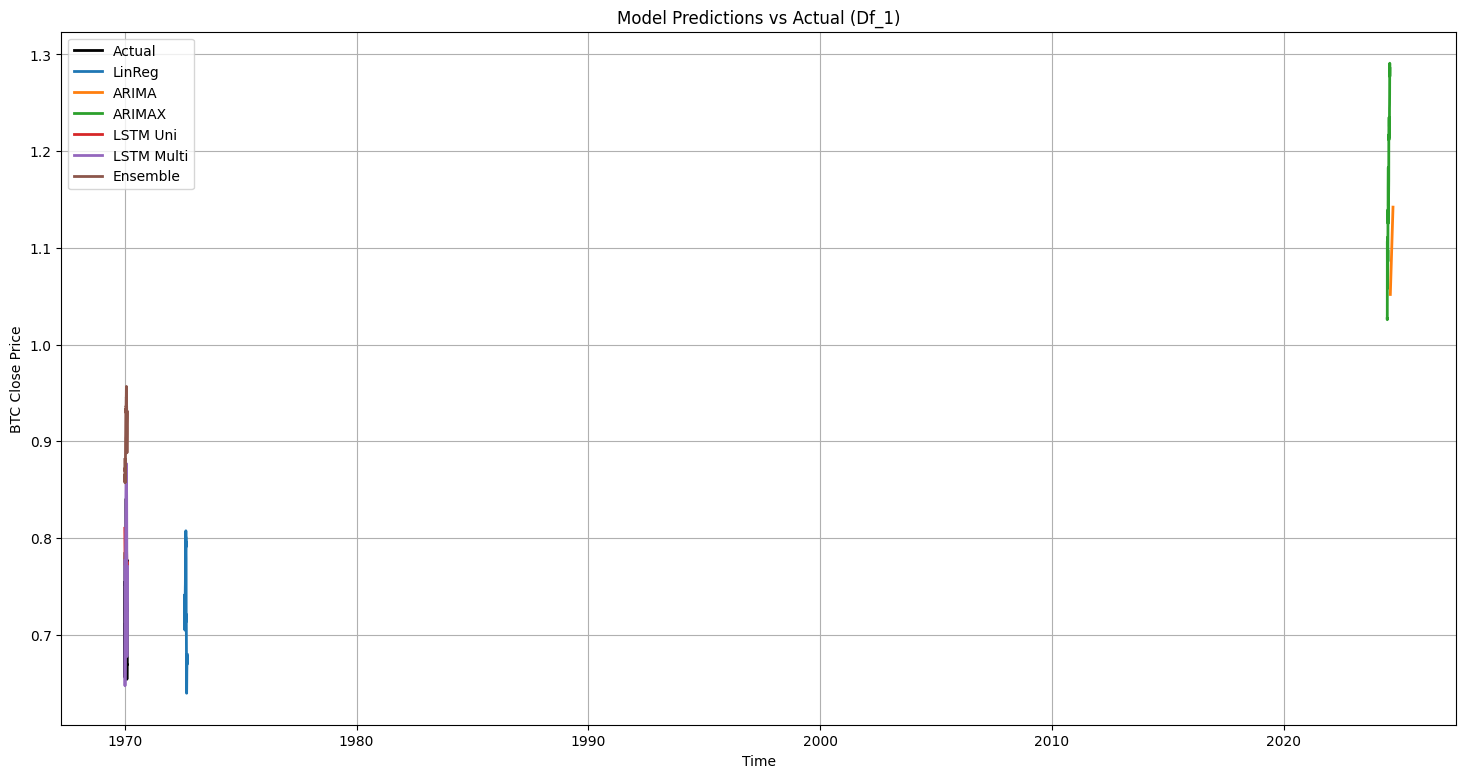

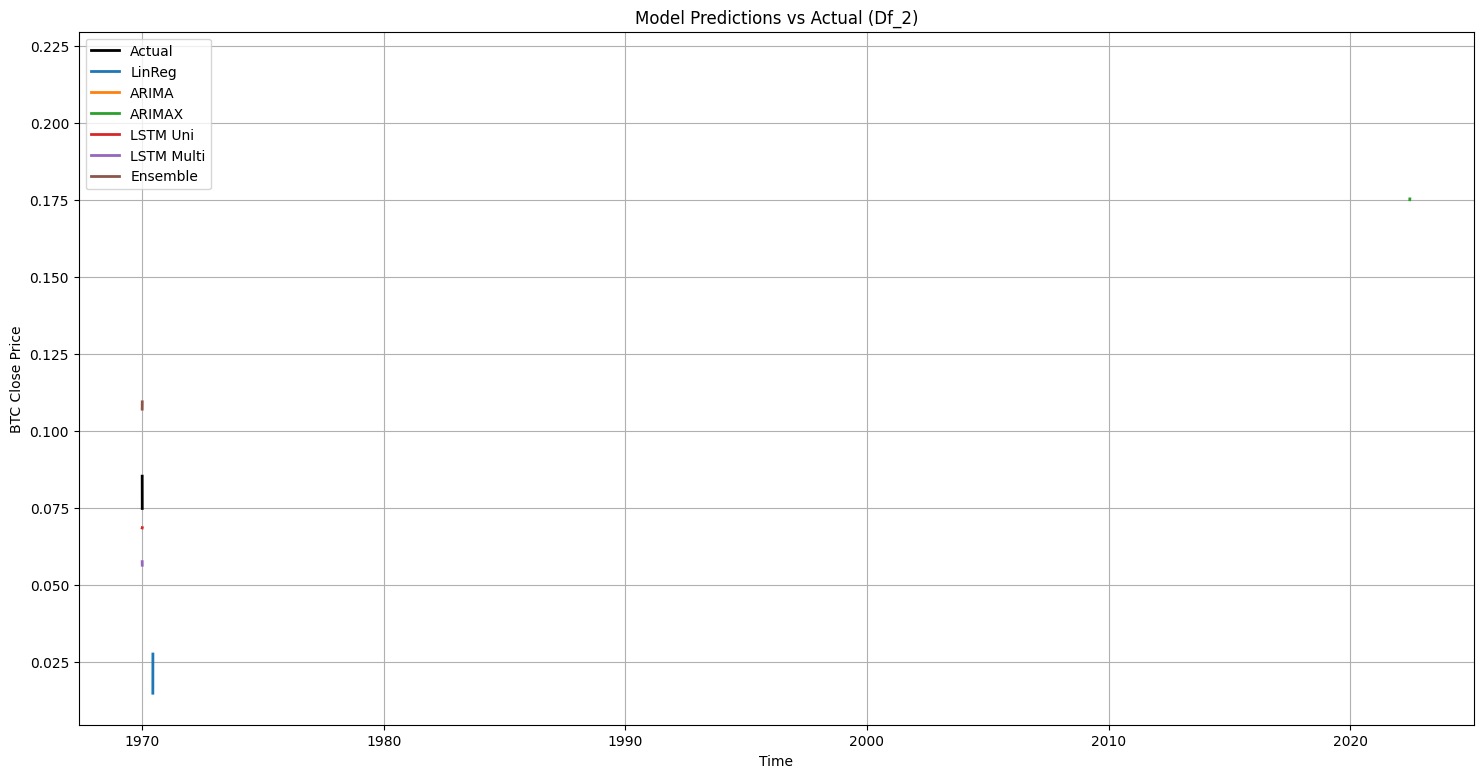

In [ ]:
#visulaizations
def plot_preds(y_true, preds_dict, title):
  plt.figure(figsize=(18,9))
  plt.plot(y_true.reset_index(drop=True), label='Actual', color='black', linewidth=2)
  for label, preds in preds_dict.items():
    plt.plot(preds, label=label, linewidth=2)
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('BTC Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_preds(
    y_true_df_1,
    {
        'LinReg': preds_linreg_df_1[n_steps:],
        'ARIMA': preds_arima_df_1[n_steps:],
        'ARIMAX': preds_arimax_df_1[n_steps:],
        'LSTM Uni': preds_lstm_uni_df_1,
        'LSTM Multi': preds_lstm_multi_df_1,
        'Ensemble': ensemble_df_1
    },
    'Model Predictions vs Actual (Df_1)'
)

plot_preds(
    y_true_df_2,
    {
        'LinReg': preds_linreg_df_2[n_steps:],
        'ARIMA': preds_arima_df_2[n_steps:],
        'ARIMAX': preds_arimax_df_2[n_steps:],
        'LSTM Uni': preds_lstm_uni_df_2,
        'LSTM Multi': preds_lstm_multi_df_2,
        'Ensemble': ensemble_df_2
    },
    'Model Predictions vs Actual (Df_2)'
)

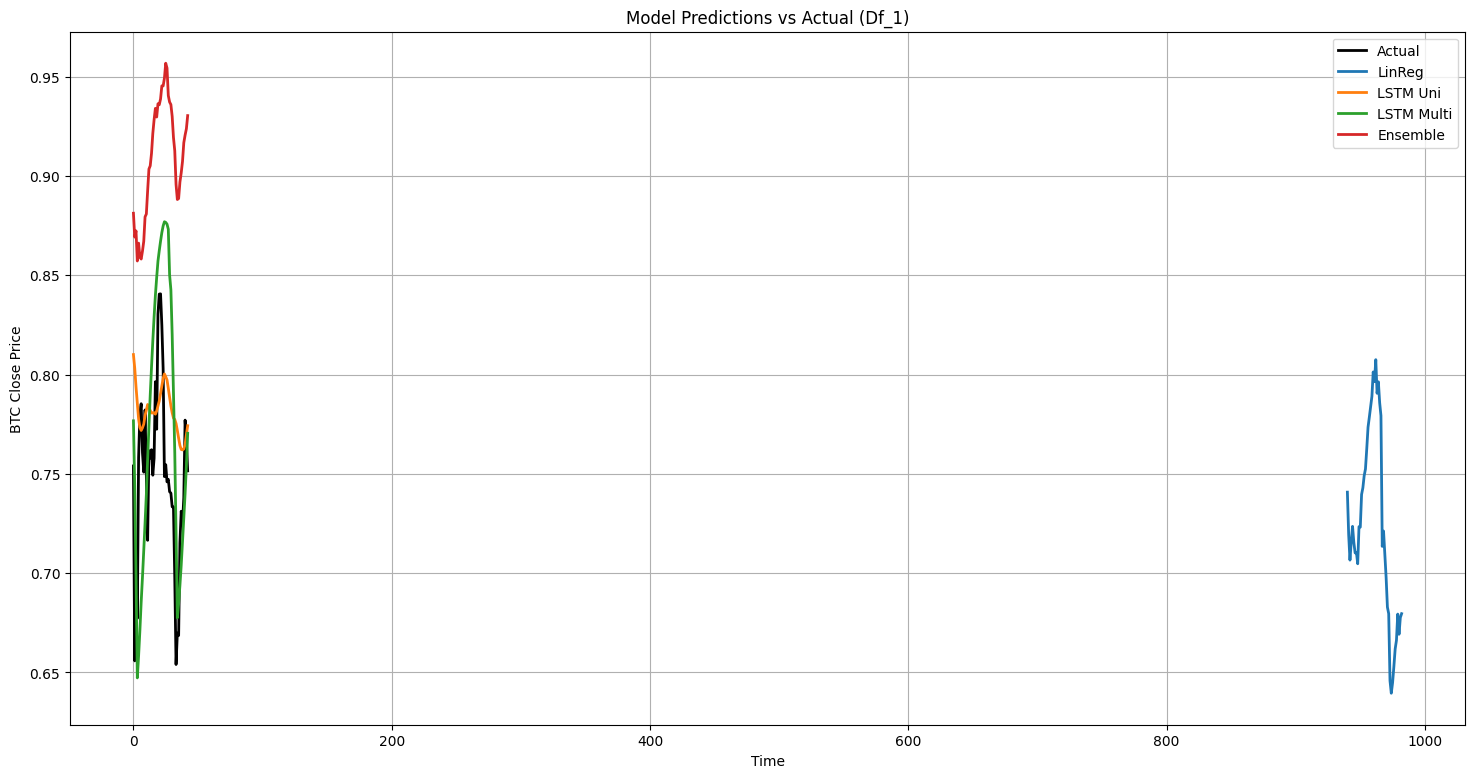

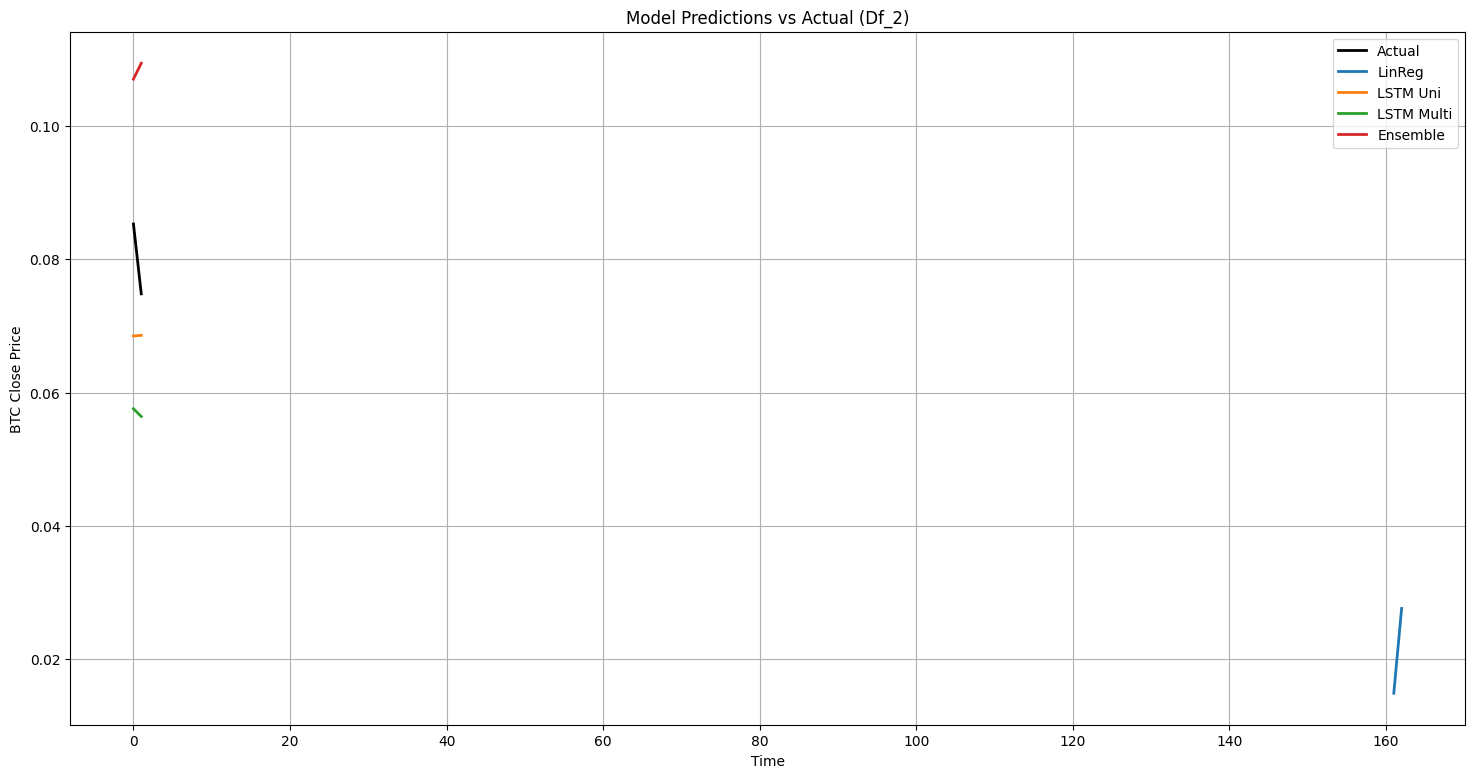

In [ ]:
#visulaizations
def plot_preds(y_true, preds_dict, title):
  plt.figure(figsize=(18,9))
  plt.plot(y_true.reset_index(drop=True), label='Actual', color='black', linewidth=2)
  for label, preds in preds_dict.items():
    plt.plot(preds, label=label, linewidth=2)
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('BTC Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_preds(
    y_true_df_1,
    {
        'LinReg': preds_linreg_df_1[n_steps:],
        'LSTM Uni': preds_lstm_uni_df_1,
        'LSTM Multi': preds_lstm_multi_df_1,
        'Ensemble': ensemble_df_1
    },
    'Model Predictions vs Actual (Df_1)'
)

plot_preds(
    y_true_df_2,
    {
        'LinReg': preds_linreg_df_2[n_steps:],
        'LSTM Uni': preds_lstm_uni_df_2,
        'LSTM Multi': preds_lstm_multi_df_2,
        'Ensemble': ensemble_df_2
    },
    'Model Predictions vs Actual (Df_2)'

)

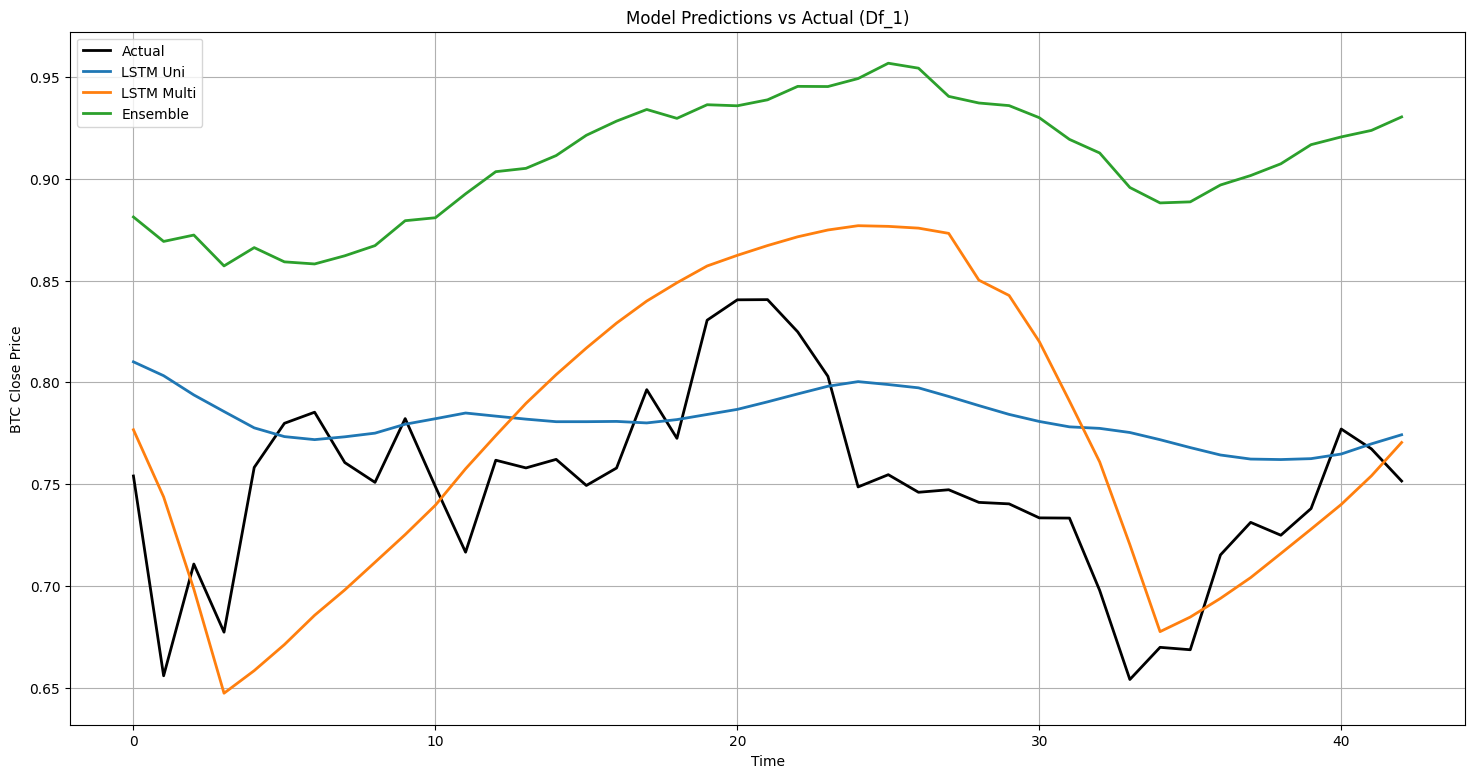

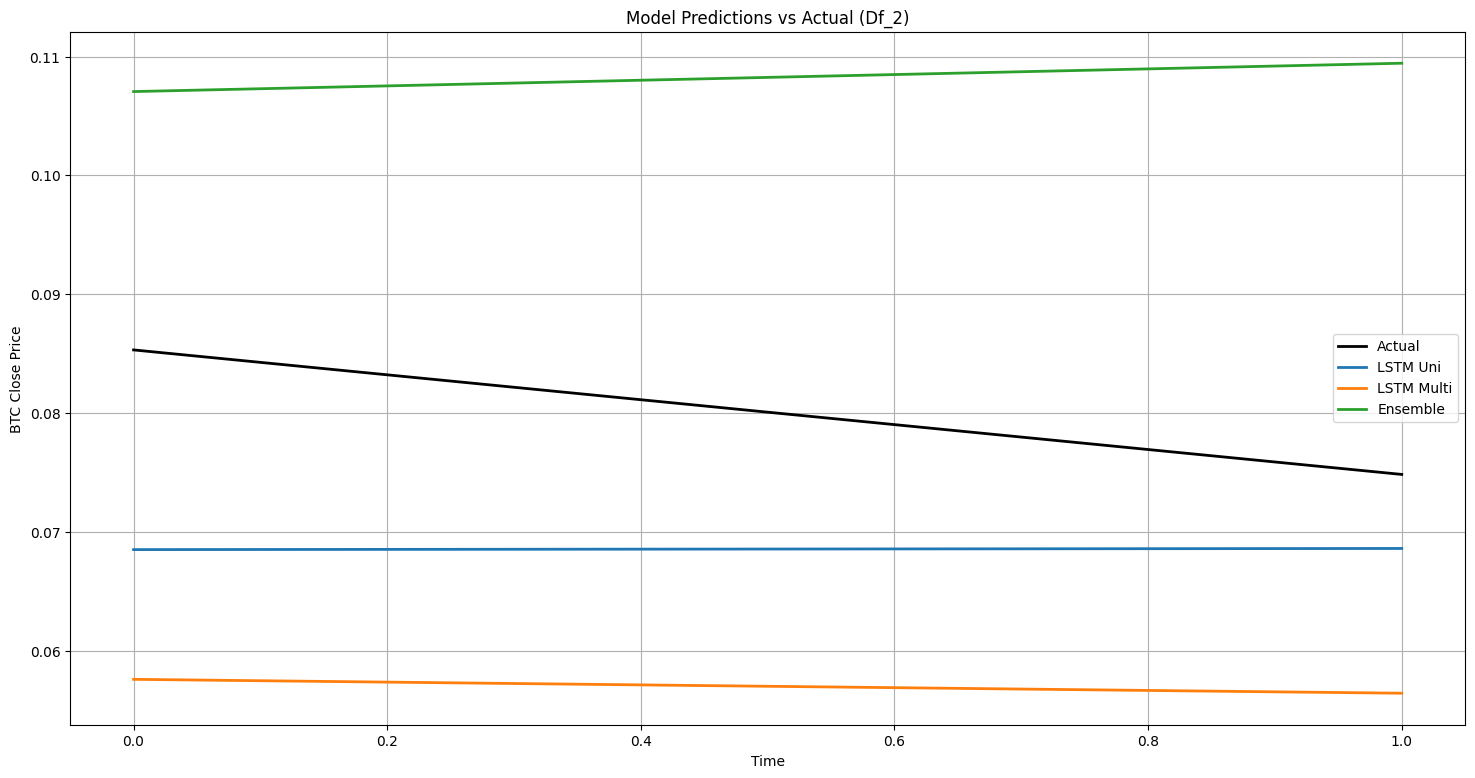

In [ ]:
#visulaizations
def plot_preds(y_true, preds_dict, title):
  plt.figure(figsize=(18,9))
  plt.plot(y_true.reset_index(drop=True), label='Actual', color='black', linewidth=2)
  for label, preds in preds_dict.items():
    plt.plot(preds, label=label, linewidth=2)
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('BTC Close Price')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_preds(
    y_true_df_1,
    {
        'LSTM Uni': preds_lstm_uni_df_1,
        'LSTM Multi': preds_lstm_multi_df_1,
        'Ensemble': ensemble_df_1
    },
    'Model Predictions vs Actual (Df_1)'
)

plot_preds(
    y_true_df_2,
    {
        'LSTM Uni': preds_lstm_uni_df_2,
        'LSTM Multi': preds_lstm_multi_df_2,
        'Ensemble': ensemble_df_2
    },
    'Model Predictions vs Actual (Df_2)'

)

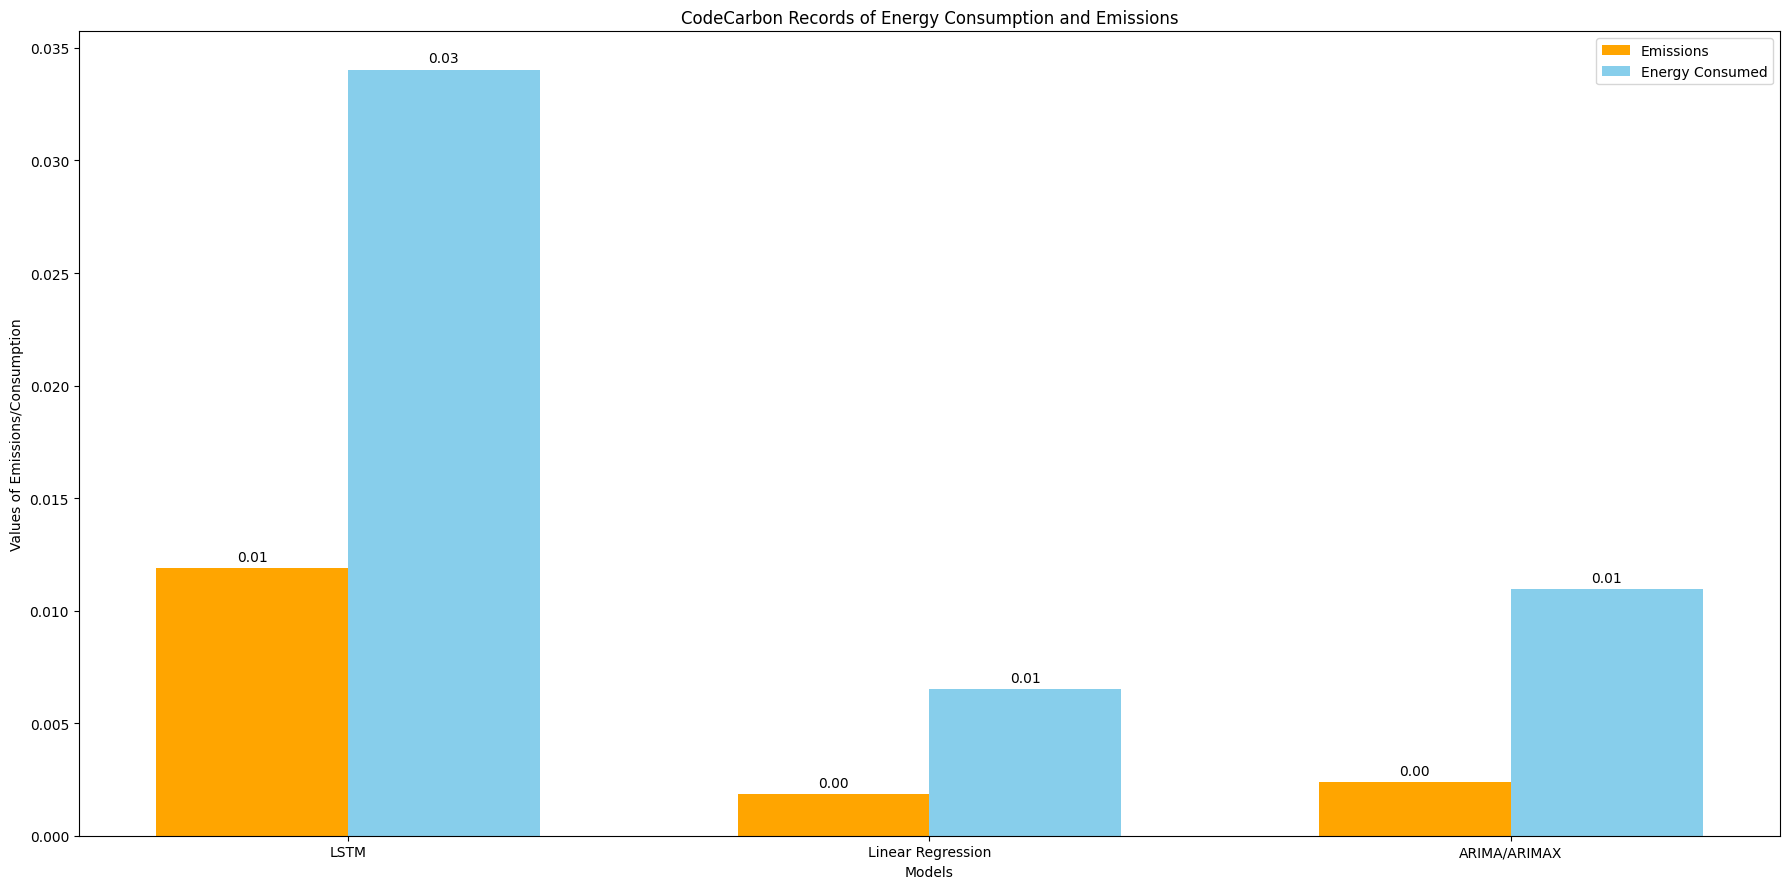

In [ ]:
#visualizing the consumption of all approaches
models = ['LSTM', 'Linear Regression', 'ARIMA/ARIMAX']
emissions = [0.0118859793, 0.001857488778, 0.002391362463]
energy_consumed = [0.03403518695, 0.006506005102, 0.01094272516]

#plot
X = np.arange(len(models))
width = 0.33
fig, ax = plt.subplots(figsize=(18,9))

#barchart for comparison
emission_bars = ax.bar(X-width/2, emissions, width, label='Emissions', color='orange')
energy_bars = ax.bar(X+width/2, energy_consumed, width, label='Energy Consumed', color='skyblue')

ax.set_xlabel('Models')
ax.set_ylabel('Values of Emissions/Consumption')
ax.set_title('CodeCarbon Records of Energy Consumption and Emissions')
ax.set_xticks(X)
ax.set_xticklabels(models)
ax.legend()

#display the value at top of bar for better readability
def value_labels(bars):
  for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')

value_labels(emission_bars)
value_labels(energy_bars)

plt.tight_layout()
plt.show()
